# Thermal Noise Simulation


Noiseless Probabilities:
  |0000000000001>: 0.0139
  |0000000000100>: 0.0882
  |0000000010000>: 0.2377
  |0000001000000>: 0.3130
  |0000100000000>: 0.2415
  |0010000000000>: 0.0891
  |1000000000000>: 0.0166

Noisy Probabilities:
  |0000000000000>: 0.8102
  |0000000000001>: 0.0059
  |0000000000100>: 0.0165
  |0000000010000>: 0.0258
  |0000001000000>: 0.0384
  |0000100000000>: 0.0367
  |0010000000000>: 0.0347
  |1000000000000>: 0.0318


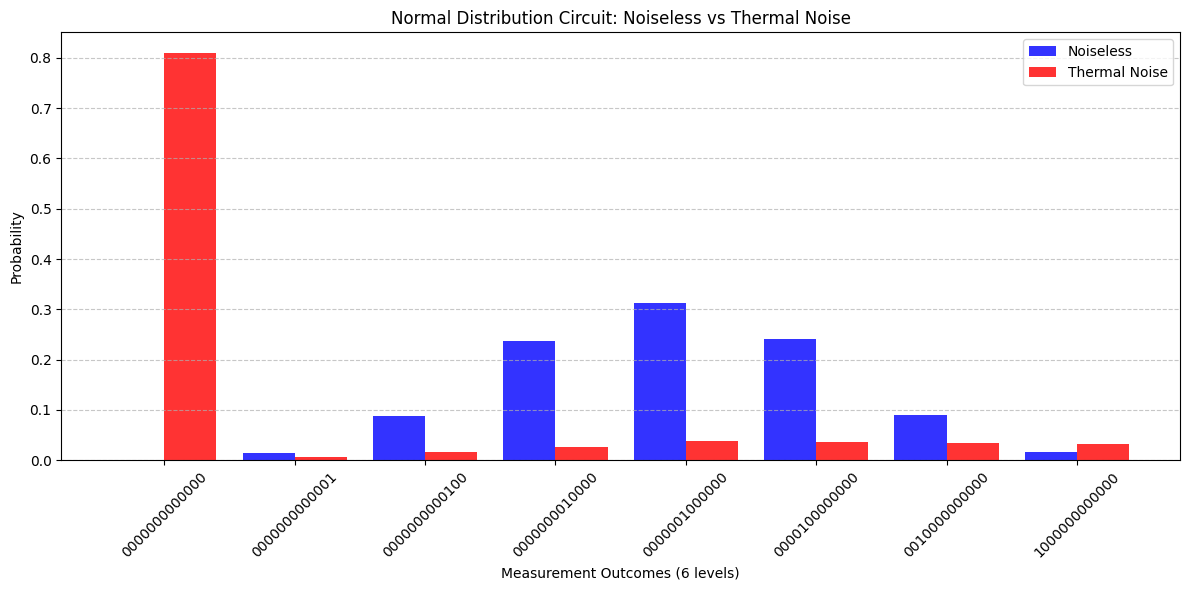

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
import matplotlib.pyplot as plt
import numpy as np


def build_normal_distribution_circuit(num_qubits: int) -> QuantumCircuit:
    """
    Constructs a quantum circuit to simulate a discretized normal-like distribution
    using a central impulse and iterative CSWAP blocks.
    """
    q = QuantumRegister(num_qubits, 'q')
    c = ClassicalRegister(num_qubits - 1, 'c')
    qc = QuantumCircuit(q, c)

    # Start with an impulse (X gate) at the center qubit
    qc.x(q[num_qubits // 2])

    # Apply CSWAP blocks to diffuse the impulse across qubits
    for block in range(1, num_qubits // 2):
        qc.reset(q[0])   # Reset ancilla to |0⟩
        qc.h(q[0])       # Put ancilla into superposition

        # Swap amplitudes symmetrically around the center
        for op in range(1, 2 * block + 1):
            left = q[num_qubits // 2 - block + op - 1]
            right = q[num_qubits // 2 - block + op]
            qc.cswap(q[0], left, right)

            if op != 2 * block:
                qc.cx(right, q[0])  # Entangle ancilla for symmetry

    # Measure every other qubit (odd-indexed) to capture the distribution
    for i in range(1, num_qubits, 2):
        qc.measure(q[i], c[i - 1])

    return qc


def build_thermal_noise_model(t1=70e3, t2=50e3, gate_time=5000):
    """
    Constructs a thermal noise model using T1 and T2 relaxation times.

    Parameters:
        t1 (float): T1 relaxation time (ns).
        t2 (float): T2 dephasing time (ns).
        gate_time (float): Gate duration (ns).
    """
    noise_model = NoiseModel()
    error_1q = thermal_relaxation_error(t1, t2, gate_time)
    error_2q = error_1q.tensor(error_1q)
    error_3q = error_1q.tensor(error_1q).tensor(error_1q)

    # Apply 1-qubit errors to relevant gates
    for gate in ['x', 'h', 'reset']:
        noise_model.add_all_qubit_quantum_error(error_1q, gate)

    # Apply 2- and 3-qubit errors to multi-qubit gates
    noise_model.add_all_qubit_quantum_error(error_2q, 'cx')
    noise_model.add_all_qubit_quantum_error(error_3q, 'cswap')
    
    return noise_model


def run_simulation(qc: QuantumCircuit, shots: int = 10000, noise_model=None):
    """
    Simulates the given quantum circuit, optionally with a noise model.

    Parameters:
        qc (QuantumCircuit): The quantum circuit to simulate.
        shots (int): Number of measurement shots.
        noise_model (NoiseModel): Optional noise model.

    Returns:
        dict: Measurement outcome counts.
    """
    simulator = AerSimulator(noise_model=noise_model)
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict) -> dict:
    """
    Converts raw measurement counts to probabilities.

    Parameters:
        counts (dict): Dictionary of measurement counts.

    Returns:
        dict: Dictionary of probabilities.
    """
    total_shots = sum(counts.values())
    return {state: count / total_shots for state, count in counts.items()}


def plot_comparison(probabilities_list, labels, colors, num_qubits):
    """
    Plots a bar chart comparing multiple probability distributions.

    Parameters:
        probabilities_list (list of dict): List of probability dictionaries.
        labels (list of str): Corresponding labels for each distribution.
        colors (list of str): Colors for each bar group.
        num_qubits (int): Number of qubits used in the circuit.
    """
    all_states = sorted(set().union(*[p.keys() for p in probabilities_list]), key=lambda x: int(x, 2))
    x = np.arange(len(all_states))
    width = 0.8 / len(probabilities_list)

    plt.figure(figsize=(12, 6))
    for i, (probs, label, color) in enumerate(zip(probabilities_list, labels, colors)):
        y = [probs.get(state, 0) for state in all_states]
        plt.bar(x + (i - len(probabilities_list) / 2) * width + width / 2, y, width,
                label=label, color=color, alpha=0.8)

    plt.xlabel(f"Measurement Outcomes ({num_qubits//2-1} levels)")
    plt.ylabel("Probability")
    plt.title("Normal Distribution Circuit: Noiseless vs Thermal Noise")
    plt.xticks(x, all_states, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def main(num_qubits=14, shots=10000):
    """
    Runs both noiseless and noisy simulations of the normal distribution circuit,
    and compares the resulting probability distributions.
    """
    qc = build_normal_distribution_circuit(num_qubits)

    # Simulate ideal (noiseless) circuit
    counts_clean = run_simulation(qc, shots=shots)
    probs_clean = calculate_probabilities(counts_clean)

    # Simulate with thermal noise
    noise_model = build_thermal_noise_model()
    counts_noisy = run_simulation(qc, shots=shots, noise_model=noise_model)
    probs_noisy = calculate_probabilities(counts_noisy)

    # Display results
    print("\nNoiseless Probabilities:")
    for state, prob in sorted(probs_clean.items(), key=lambda x: int(x[0], 2)):
        print(f"  |{state}>: {prob:.4f}")

    print("\nNoisy Probabilities:")
    for state, prob in sorted(probs_noisy.items(), key=lambda x: int(x[0], 2)):
        print(f"  |{state}>: {prob:.4f}")

    # Plot probability comparison
    plot_comparison(
        probabilities_list=[probs_clean, probs_noisy],
        labels=["Noiseless", "Thermal Noise"],
        colors=["blue", "red"],
        num_qubits=num_qubits
    )


if __name__ == "__main__":
    main(num_qubits=14, shots=10000)


# Noise Optimization Using ZNE (Zero Noise Extrapolation)

Running quantum normal distribution simulation with 10 qubits...
Shots: 10000, Repetition factor: 3
Original circuit depth: 45

1. Running noiseless simulation...
2. Running noisy simulation...
3. Running zero-noise extrapolation...

Method                    Fidelity vs Noiseless
---------------------------------------------
Noisy                     0.6124              
Zero-Noise Extrapolated   0.9753              


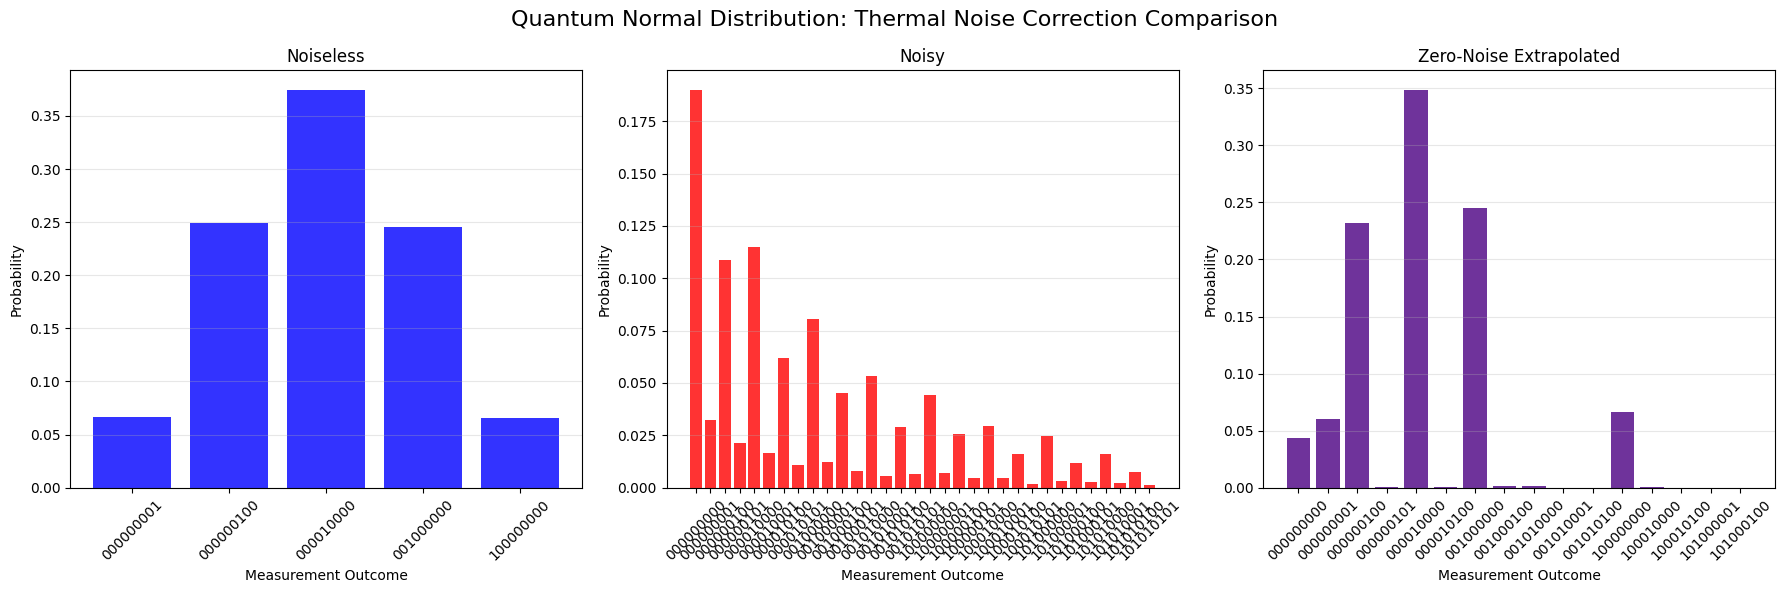

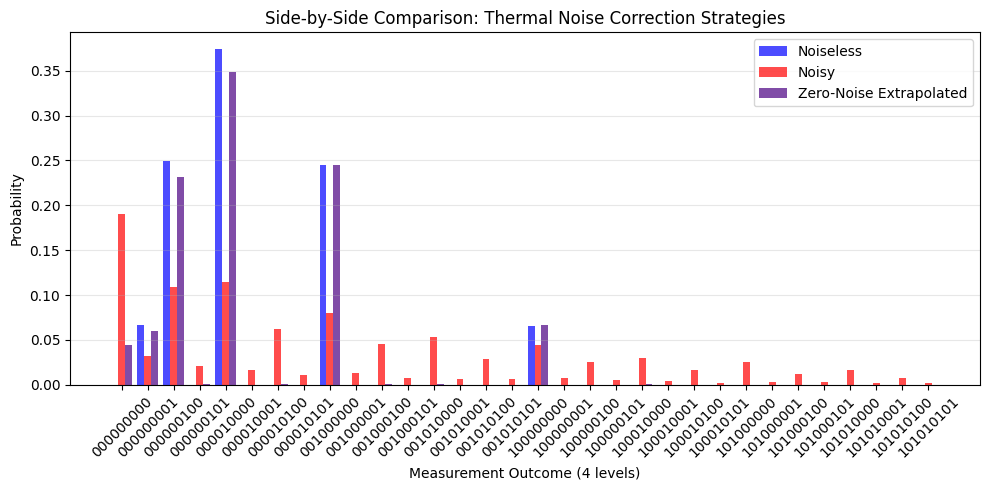

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, depolarizing_error
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


def build_normal_distribution_circuit(num_qubits: int) -> QuantumCircuit:
    """
    Constructs a quantum circuit that approximates a normal distribution
    through a central impulse and CSWAP diffusion steps.
    """
    q = QuantumRegister(num_qubits, 'q')
    c = ClassicalRegister(num_qubits - 1, 'c')
    qc = QuantumCircuit(q, c)

    # Initialize central qubit with an impulse
    qc.x(q[num_qubits // 2])

    # Create diffusion outward from center using CSWAP-based spread
    for block in range(1, num_qubits // 2):
        qc.reset(q[0])       # Ancilla reset
        qc.h(q[0])           # Superposition for symmetric diffusion

        for op in range(1, 2 * block + 1):
            left = q[num_qubits // 2 - block + op - 1]
            right = q[num_qubits // 2 - block + op]
            qc.cswap(q[0], left, right)

            if op != 2 * block:
                qc.cx(right, q[0])  # Maintain ancilla entanglement structure

    # Measure every other qubit (odd-indexed)
    for i in range(1, num_qubits, 2):
        qc.measure(q[i], c[i - 1])

    return qc


def build_thermal_noise_model(t1=50e3, t2=7e3, gate_time=1000, depol_prob=0.05):
    """
    Builds a noise model incorporating thermal relaxation and depolarizing noise.
    """
    noise_model = NoiseModel()

    # Construct combined 1-qubit noise
    thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
    depol_1q = depolarizing_error(depol_prob, 1)
    combined_1q = thermal_1q.compose(depol_1q)

    # Construct combined 2-qubit noise
    thermal_2q = thermal_1q.tensor(thermal_1q)
    depol_2q = depolarizing_error(depol_prob * 2, 2)
    combined_2q = thermal_2q.compose(depol_2q)

    # Construct combined 3-qubit noise
    thermal_3q = thermal_1q.tensor(thermal_1q).tensor(thermal_1q)
    depol_3q = depolarizing_error(depol_prob * 3, 3)
    combined_3q = thermal_3q.compose(depol_3q)

    # Assign noise to gate types
    for gate in ['x', 'h', 'reset']:
        noise_model.add_all_qubit_quantum_error(combined_1q, gate)
    
    noise_model.add_all_qubit_quantum_error(combined_2q, 'cx')
    noise_model.add_all_qubit_quantum_error(combined_3q, 'cswap')

    return noise_model


def run_simulation(qc: QuantumCircuit, shots: int = 10000, use_noise: bool = True):
    """
    Runs the circuit simulation, optionally using a thermal noise model.
    """
    if use_noise:
        noise_model = build_thermal_noise_model()
        simulator = AerSimulator(noise_model=noise_model)
    else:
        simulator = AerSimulator()
    
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict) -> dict:
    """
    Converts raw measurement counts into normalized probabilities.
    """
    total_shots = sum(counts.values())
    return {state: count / total_shots for state, count in counts.items()}


def calculate_fidelity(probs1: dict, probs2: dict) -> float:
    """
    Computes the classical fidelity between two probability distributions.
    """
    all_states = set(probs1.keys()) | set(probs2.keys())
    return sum(np.sqrt(probs1.get(s, 0) * probs2.get(s, 0)) for s in all_states)


def plot_comprehensive_comparison(results_dict: dict, num_qubits: int):
    """
    Plots individual and side-by-side comparisons of different probability distributions.
    """
    all_nonzero_states = set()
    for probs in results_dict.values():
        all_nonzero_states.update([s for s, p in probs.items() if p > 0])

    all_states = sorted(all_nonzero_states, key=lambda s: int(s, 2) if s else 0)
    n_methods = len(results_dict)

    # Subplot for individual comparisons
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Quantum Normal Distribution: Thermal Noise Correction Comparison', fontsize=16)
    
    colors = ['blue', 'red', 'indigo']
    for idx, (label, probs) in enumerate(results_dict.items()):
        ax = axes[idx]
        nonzero_states = [s for s in probs if probs[s] > 0]
        nonzero_states.sort(key=lambda s: int(s, 2))
        values = [probs[s] for s in nonzero_states]

        ax.bar(range(len(nonzero_states)), values, color=colors[idx % len(colors)], alpha=0.8)
        ax.set_xticks(range(len(nonzero_states)))
        ax.set_xticklabels(nonzero_states, rotation=45)
        ax.set_title(f'{label}', fontsize=12)
        ax.set_xlabel('Measurement Outcome')
        ax.set_ylabel('Probability')
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Side-by-side plot
    plt.figure(figsize=(10, 5))
    x = np.arange(len(all_states))
    width = 0.8 / n_methods

    for idx, (label, probs) in enumerate(results_dict.items()):
        probs_list = [probs.get(state, 0) for state in all_states]
        offset = (idx - n_methods / 2 + 0.5) * width
        plt.bar(x + offset, probs_list, width, label=label,
                color=colors[idx % len(colors)], alpha=0.7)

    plt.xlabel(f'Measurement Outcome ({num_qubits // 2 - 1} levels)')
    plt.ylabel('Probability')
    plt.title('Side-by-Side Comparison: Thermal Noise Correction Strategies')
    plt.xticks(x, all_states, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def main(num_qubits=10, shots=5000, repetition_factor=3):
    """
    Runs full simulation: noiseless, noisy, and zero-noise extrapolated.
    Also computes fidelity comparisons and plots results.
    """
    print(f"Running quantum normal distribution simulation with {num_qubits} qubits...")
    print(f"Shots: {shots}, Repetition factor: {repetition_factor}")

    qc = build_normal_distribution_circuit(num_qubits)
    print(f"Original circuit depth: {qc.depth()}")

    results = {}
    fidelities = {}

    # Noiseless baseline
    print("\n1. Running noiseless simulation...")
    counts_clean = run_simulation(qc, shots=shots, use_noise=False)
    probs_clean = calculate_probabilities(counts_clean)
    results['Noiseless'] = probs_clean

    # Noisy simulation
    print("2. Running noisy simulation...")
    counts_noisy = run_simulation(qc, shots=shots, use_noise=True)
    probs_noisy = calculate_probabilities(counts_noisy)
    results['Noisy'] = probs_noisy
    fidelities['Noisy'] = calculate_fidelity(probs_clean, probs_noisy)

    # Zero-Noise Extrapolation (ZNE)
    print("3. Running zero-noise extrapolation...")
    noise_levels = [0.5, 1.0, 1.5]
    noise_results = []

    for factor in noise_levels:
        temp_noise_model = build_thermal_noise_model(
            t1=50e3 / factor, t2=7e3 / factor, depol_prob=0.001 * factor
        )
        simulator = AerSimulator(noise_model=temp_noise_model)
        compiled = transpile(qc, simulator)
        job = simulator.run(compiled, shots=shots)
        counts = job.result().get_counts(qc)
        probs = calculate_probabilities(counts)
        noise_results.append(probs)

    # Linear extrapolation for each state
    extrapolated_probs = {}
    all_states = set().union(*[p.keys() for p in noise_results])

    for state in all_states:
        y_vals = [p.get(state, 0) for p in noise_results]
        if len(set(y_vals)) > 1:  # Extrapolate only if there's variation
            coeffs = np.polyfit(noise_levels, y_vals, 1)
            extrapolated_prob = coeffs[1]  # y-intercept (noise-free estimate)
            if extrapolated_prob > 0:
                extrapolated_probs[state] = max(0, extrapolated_prob)

    # Normalize extrapolated distribution
    total = sum(extrapolated_probs.values())
    if total > 0:
        extrapolated_probs = {s: p / total for s, p in extrapolated_probs.items()}

    results['Zero-Noise Extrapolated'] = extrapolated_probs
    fidelities['Zero-Noise Extrapolated'] = calculate_fidelity(probs_clean, extrapolated_probs)

    # Print fidelity summary
    print(f"\n{'Method':<25} {'Fidelity vs Noiseless':<20}")
    print("-" * 45)
    for method, fidelity in fidelities.items():
        print(f"{method:<25} {fidelity:<20.4f}")

    # Plot
    plot_comprehensive_comparison(results, num_qubits)

    return results, fidelities


if __name__ == "__main__":
    results, fidelities = main(num_qubits=10, shots=10000, repetition_factor=3)
